<div style="padding:5px; font-size: 24px; font-weight: bold; text-align: center">FINAL DECISION </div>

In [70]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#Supress warnings
import warnings
warnings.filterwarnings("ignore")

<div style="padding:10px; font-size:18px; background-color: lightblue; font-weight:bold; font-style: italic">Data Processing And Preparation </div>

In [72]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [73]:
# Reading the Dataset
df_test = pd.read_csv('Test_data.csv')

In [74]:
df_test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [75]:
df_test.shape

(23490, 13)

In [76]:
df_test = df_test.drop('employee_id', axis=1)

In [77]:
# Check for duplicate rows if any available
df_test.duplicated().sum()
df_test.drop_duplicates(inplace=True)
df_test.duplicated().sum()

0

<b>Converting gender to Binary variables (m/f) to 1/0   

In [78]:
print(df_test['gender'].value_counts())
df_test['gender'].value_counts(normalize=True) * 100  # Percentage
imbalance_ratio = (df_test['gender'] == 0).sum() / (df_test['gender'] == 1).sum()
imbalance_ratio 

gender
m    16574
f     6890
Name: count, dtype: int64


nan

In [79]:
#Since there are null values let us check for the count of missing values in each column
df_test.isnull().sum()

department                 0
region                     0
education               1030
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1797
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [80]:
# checking number of unique values in each column
df_test.nunique()

department               9
region                  34
education                3
gender                   2
recruitment_channel      3
no_of_trainings          9
age                     41
previous_year_rating     5
length_of_service       34
KPIs_met >80%            2
awards_won?              2
avg_training_score      61
dtype: int64

In [81]:
# Calculating Missing Values Percentage
100*(df_test.isna().mean()).sort_values(ascending = False)

previous_year_rating    7.658541
education               4.389703
department              0.000000
region                  0.000000
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
dtype: float64

<div style="padding:10px; font-size:18px; font-weight:bold; font-style: italic"><b> Categorical Column</div>

<b> so we are imputing the missing values using the mode for Categorical columns and Median for Numerical columns.

In [84]:
# education missing values to be imputed with mode
df_test['education'].fillna(df_test['education'].mode()[0], inplace=True)

<div style="padding:10px; font-size:18px; font-weight:bold; font-style: italic"><b> Numerical Column</div>

<b> checking Outliers

In [87]:
#Calculate Q1 (25th percentile) and Q3 (75th percentile)
quartile_1 = df_test['previous_year_rating'].quantile(0.25)
quartile_3 = df_test['previous_year_rating'].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = quartile_3 - quartile_1

# Define lower and upper bounds for outliers
lower_bound = quartile_1 - 1.5 * IQR
upper_bound = quartile_3 + 1.5 * IQR

# Filter out the outliers
outliers = df_test[(df_test['previous_year_rating'] < lower_bound) | 
                       (df_test['previous_year_rating'] > upper_bound)]

# Print the number of outliers found
print("Number of outliers in 'previous_year_rating':", outliers.shape[0])

Number of outliers in 'previous_year_rating': 2679


In [88]:
# Using the median based on the above output
df_test['previous_year_rating'].fillna(df_test['previous_year_rating'].median(), inplace=True)

In [89]:
#verify that there is not any missing values
df_test.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

In [90]:
#Train-Test Split
# Create X and y
X = df_test.drop('previous_year_rating', axis=1)
y = df_test['previous_year_rating']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [91]:
import xgboost as xgb
# Adjust target variable labels to start from 0
y = y - 1  # Subtract 1 from each class label to make it start from 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

In [92]:
# CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

In [93]:
import lightgbm as lgb
# LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 18771, number of used features: 51
[LightGBM] [Info] Start training from score -2.169640
[LightGBM] [Info] Start training from score -2.616773
[LightGBM] [Info] Start training from score -0.876012
[LightGBM] [Info] Start training from score -1.715918
[LightGBM] [Info] Start training from score -1.530145


In [94]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

def evaluate_model(y_true, y_pred, model_name, y_probs=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multiclass
    rec = recall_score(y_true, y_pred, average='macro')      # Use 'macro' for multiclass
    f1 = f1_score(y_true, y_pred, average='macro')            # Use 'macro' for multiclass
    auc = roc_auc_score(y_true, y_probs, average='macro', multi_class='ovr') if y_probs is not None else np.nan  # For multiclass AUC
    return {'Model': model_name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc}

# XGBoost
xgb_probs = xgb_model.predict_proba(X_test)
xgb_metrics = evaluate_model(y_test, xgb_preds, 'XGBoost', xgb_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([xgb_metrics])], ignore_index=True)

# CatBoost
cat_probs = cat_model.predict_proba(X_test)
cat_metrics = evaluate_model(y_test, cat_preds, 'CatBoost', cat_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([cat_metrics])], ignore_index=True)

# LightGBM
lgb_probs = lgb_model.predict_proba(X_test)
lgb_metrics = evaluate_model(y_test, lgb_preds, 'LightGBM', lgb_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([lgb_metrics])], ignore_index=True)

print(metrics_df)

      Model  Accuracy  Precision    Recall        F1       AUC
0   XGBoost  0.450671   0.326642  0.295397  0.269893  0.682280
1  CatBoost  0.448540   0.297383  0.294137  0.270433  0.683629
2  LightGBM  0.453441   0.309406  0.290073  0.253601  0.686532


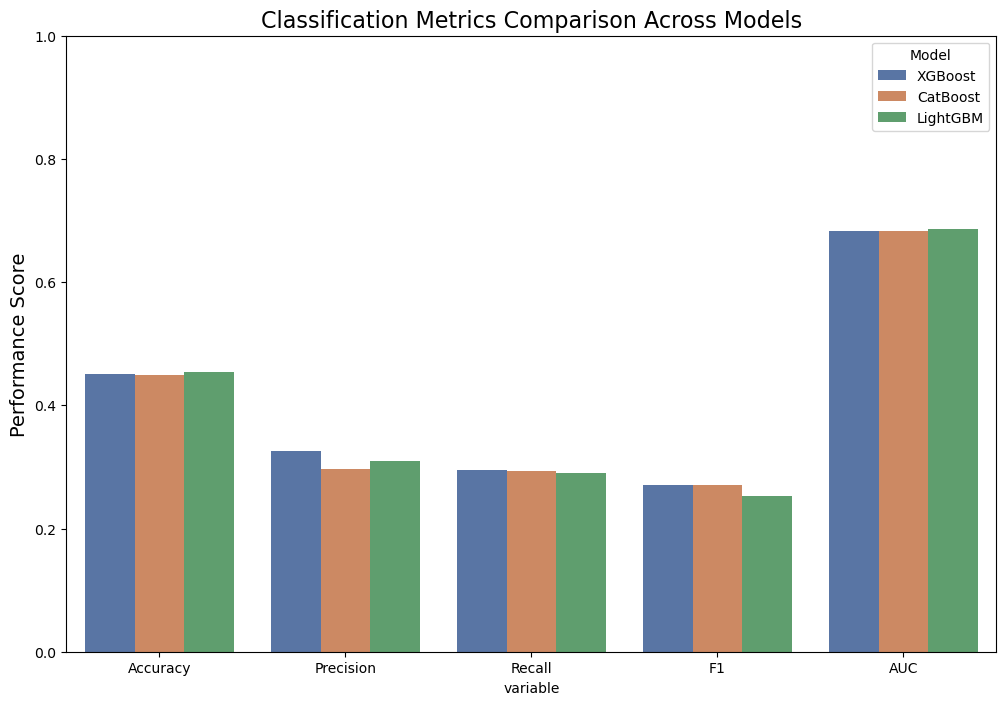

In [95]:
# Visualisation of the models
sns.set_palette('deep')
plt.figure(figsize=(12,8))
melted = metrics_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
sns.barplot(x='variable', y='value', hue='Model', data=melted)
plt.title('Classification Metrics Comparison Across Models',fontsize=16)
plt.ylabel('Performance Score', fontsize=14)
plt.ylim(0,1)
plt.show()